# House Price Data Cleaning

## Import library

In [29]:
# Import necessary Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder, StandardScaler

## Load Dataset

In [30]:
data_path = 'house_price.csv'

house_price = pd.read_csv(data_path)

## Dataset Info

In [31]:
house_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Group all Columns by their Data type.

In [32]:
# int64 columns
int_columns = ["OverallQual", "OverallCond", "BsmtFullBath", "BsmtHalfBath",
"FullBath", "HalfBath", "BedroomAbvGr", "KitchenAbvGr", "TotRmsAbvGrd", "Fireplaces", "GarageCars"]

# datetime columns
datetime_columns = ["YearBuilt", "YearRemodAdd", "GarageYrBlt", "MoSold", "YrSold"]
# the fact is columns only contain year or month, we can treat this as integer later

# float64 columns
float_columns = ["LotFrontage", "LotArea", "MasVnrArea", "BsmtFinSF1",
"BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "1stFlrSF", "2ndFlrSF", "LowQualFinSF",
"GrLivArea", "GarageArea", "WoodDeckSF", "OpenPorchSF", "EnclosedPorch",
"3SsnPorch", "ScreenPorch", "PoolArea", "MiscVal"]

# ordinal columns (dtype is equal to object/categoric, but these are actually ordinal features)
ordinal_columns = ["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1",
"BsmtFinType2", "HeatingQC", "CentralAir", "KitchenQual", "GarageFinish",
"GarageQual", "GarageCond", "PavedDrive", "PoolQC", "Fence"]

# categorical columns
obj_columns = ["MSSubClass", "MSZoning", "Alley", "Street", "LotShape", "LandContour",
"Utilities", "LotConfig", "LandSlope", "Neighborhood", "Condition1",
"Condition2", "BldgType", "HouseStyle", "OverallQual", "RoofStyle",
"RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "ExterQual",
"ExterCond", "Foundation", "Heating", "Electrical", "Functional", "FireplaceQu",
"GarageType", "MiscFeature", "SaleType", "SaleCondition"]

# target column
target_column = ["SalePrice"]

## Missing Value

### Check Missing Value

In [33]:
# sum all missing value in dataset and keep only columns with missing value > 0
missing = house_price.isnull().sum()[house_price.isnull().sum() > 0]

# construct a dataframe consists of NaN count and NaN percentage from the dataset
missing_house_price_summary = pd.DataFrame({
    'NaN_count': missing, 
    'NaN_percentage': round(((missing / len(house_price)) * 100),3)
    }).sort_values(by = 'NaN_percentage', ascending = False)

# print the missing value information
missing_house_price_summary

,NaN_count,NaN_percentage
PoolQC,1453,99.521
MiscFeature,1406,96.301
Alley,1369,93.767
Fence,1179,80.753
MasVnrType,872,59.726
FireplaceQu,690,47.260
LotFrontage,259,17.740
GarageType,81,5.548
GarageYrBlt,81,5.548
GarageFinish,81,5.548


### Handling Missing Value

Based on the original data source (read: [house_price_source](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data)), each column in the data has been defined. So, based on this definition, there are several columns where the NA (*missing value*) value is actually not a *missing value* but rather has the meaning **None** (hereinafter referred to as *legit NA*)

So, the handling of NA values ​​in the *legit NA* column will be different from the NA *missing value* column.

In [34]:
# specify columns with legit na values
legit_na_values_columns = ["MasVnrArea", "MasVnrType", "BsmtExposure", "BsmtCond", "BsmtFinType1",
                          "BsmtFinType2", "BsmtQual", "GarageCond", "GarageQual",
                          "GarageFinish", "GarageType", "Fireplaces", "Fence", "Alley", "MiscFeature",
                          "PoolQC", "GarageYrBlt", "FireplaceQu"]

# print how many columns with legit na values
print(f'number of columns with legit NA values: {len(legit_na_values_columns)}')

number of columns with legit NA values: 18


In [35]:
house_price[legit_na_values_columns].sample(5)

,MasVnrArea,MasVnrType,BsmtExposure,BsmtCond,BsmtFinType1,BsmtFinType2,BsmtQual,GarageCond,GarageQual,GarageFinish,GarageType,Fireplaces,Fence,Alley,MiscFeature,PoolQC,GarageYrBlt,FireplaceQu
678,464.0,Stone,Mn,TA,Unf,Unf,Ex,TA,TA,Fin,Attchd,1,NaN,NaN,NaN,NaN,2008.0,Gd
903,27.0,BrkFace,No,TA,Unf,Unf,Gd,TA,TA,RFn,Attchd,1,NaN,NaN,NaN,NaN,2006.0,Gd
479,435.0,BrkCmn,No,TA,Rec,Unf,Fa,TA,TA,Unf,Detchd,0,MnPrv,NaN,NaN,NaN,1995.0,NaN
718,651.0,BrkFace,Gd,TA,GLQ,Unf,Gd,TA,TA,RFn,Attchd,1,NaN,NaN,NaN,NaN,1993.0,TA
6,186.0,Stone,Av,TA,GLQ,Unf,Ex,TA,TA,RFn,Attchd,1,NaN,NaN,NaN,NaN,2004.0,Gd


To know the right handling method, we have to separate the columns with numeric data types and categorical data types.

In [36]:
# specify columns with numeric dtype
num_legit_na = [i for i in house_price[legit_na_values_columns].columns if house_price[i].dtype in ["int", "float"]]

# print how many columns with legit na values (numeric)
print(f'Number of numeric columns with legit NA values: {len(num_legit_na)} ({num_legit_na})')

Number of numeric columns with legit NA values: 3 (['MasVnrArea', 'Fireplaces', 'GarageYrBlt'])


In [37]:
# specify columns with categoric dtype
cat_legit_na = [i for i in house_price[legit_na_values_columns].columns if house_price[i].dtype=="object"]

# print how many columns with legit na values (numeric)
print(f'number of categorical columns with legit NA values: {len(cat_legit_na)} ({cat_legit_na})')

number of categorical columns with legit NA values: 15 (['MasVnrType', 'BsmtExposure', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'GarageCond', 'GarageQual', 'GarageFinish', 'GarageType', 'Fence', 'Alley', 'MiscFeature', 'PoolQC', 'FireplaceQu'])


To prevent unwanted things from happening, backup the original dataset.

In [38]:
# copy the initial dataset to backup if any incident happens
house_price_handled = house_price.copy()

**Handling NA Values in numeric columns by 0**

In [39]:
# knowing that GarageYrBlt is of type datetime, best way to handle it is by removing it.
num_legit_na.remove("GarageYrBlt")

In [40]:
# handle missing value in datetime column by removing it
house_price_handled.dropna(subset=["GarageYrBlt"], inplace=True)

In [41]:
# Filling all numerical columns legit NA values with 0
house_price_handled[num_legit_na] = house_price_handled[num_legit_na].fillna(0)

In [42]:
# check the filling result
house_price_handled[num_legit_na].isna().sum()

MasVnrArea    0
Fireplaces    0
dtype: int64

In [43]:
# Check GarageYrBlt dropping na
house_price_handled['GarageYrBlt'].isna().sum()

0

**Filling Na values on numerical columns is completed!**

In [44]:
# Filling all categorical columns legit NA values with 'not_exist'
house_price_handled[cat_legit_na] = house_price_handled[cat_legit_na].fillna('not_exist')

In [45]:
# check the filling result
house_price_handled[cat_legit_na].isna().sum()

MasVnrType      0
BsmtExposure    0
BsmtCond        0
BsmtFinType1    0
BsmtFinType2    0
BsmtQual        0
GarageCond      0
GarageQual      0
GarageFinish    0
GarageType      0
Fence           0
Alley           0
MiscFeature     0
PoolQC          0
FireplaceQu     0
dtype: int64

**Replacing Na values on categorical columns is completed!**

In [46]:
house_price_handled

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,not_exist,Reg,Lvl,AllPub,...,0,not_exist,not_exist,not_exist,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,not_exist,Reg,Lvl,AllPub,...,0,not_exist,not_exist,not_exist,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,not_exist,IR1,Lvl,AllPub,...,0,not_exist,not_exist,not_exist,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,not_exist,IR1,Lvl,AllPub,...,0,not_exist,not_exist,not_exist,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,not_exist,IR1,Lvl,AllPub,...,0,not_exist,not_exist,not_exist,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,not_exist,Reg,Lvl,AllPub,...,0,not_exist,not_exist,not_exist,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,not_exist,Reg,Lvl,AllPub,...,0,not_exist,MnPrv,not_exist,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,not_exist,Reg,Lvl,AllPub,...,0,not_exist,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,not_exist,Reg,Lvl,AllPub,...,0,not_exist,not_exist,not_exist,0,4,2010,WD,Normal,142125


In [47]:
# merge the handled missing value dataframe with original one
house_price_merged = pd.merge(house_price, house_price_handled, how="right").copy()
house_price_merged

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,not_exist,Reg,Lvl,AllPub,...,0,not_exist,not_exist,not_exist,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,not_exist,Reg,Lvl,AllPub,...,0,not_exist,not_exist,not_exist,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,not_exist,IR1,Lvl,AllPub,...,0,not_exist,not_exist,not_exist,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,not_exist,IR1,Lvl,AllPub,...,0,not_exist,not_exist,not_exist,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,not_exist,IR1,Lvl,AllPub,...,0,not_exist,not_exist,not_exist,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1374,1456,60,RL,62.0,7917,Pave,not_exist,Reg,Lvl,AllPub,...,0,not_exist,not_exist,not_exist,0,8,2007,WD,Normal,175000
1375,1457,20,RL,85.0,13175,Pave,not_exist,Reg,Lvl,AllPub,...,0,not_exist,MnPrv,not_exist,0,2,2010,WD,Normal,210000
1376,1458,70,RL,66.0,9042,Pave,not_exist,Reg,Lvl,AllPub,...,0,not_exist,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1377,1459,20,RL,68.0,9717,Pave,not_exist,Reg,Lvl,AllPub,...,0,not_exist,not_exist,not_exist,0,4,2010,WD,Normal,142125


Merge the data whose missing values ​​have been handled with the initial data.

In [48]:
# sum all missing value in dataset and keep only columns with missing value > 0
missing = house_price_merged.isnull().sum()[house_price_merged.isnull().sum() > 0]

# construct a dataframe consists of NaN count and NaN percentage from the dataset
missing_house_price_summary = pd.DataFrame({
    'NaN_count': missing, 
    'NaN_percentage': round(((missing / len(house_price_merged)) * 100),3)
    }).sort_values(by = 'NaN_percentage', ascending = False)

# print the missing value information
missing_house_price_summary

,NaN_count,NaN_percentage
LotFrontage,252,18.274
Electrical,1,0.073


**Handling Real Missing Values**

in order to choose right imputation method. we need to analyze some of the feature intrinsic information, such as:
* feature mean,
* feature median,
* feature data shape,

**LotFrontage**

In [49]:
# descriptive statistics of LotFrontage
house_price_merged.LotFrontage.describe()

count    1127.000000
mean       70.683230
std        24.261598
min        21.000000
25%        60.000000
50%        70.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

Visualize LotFrontage Column

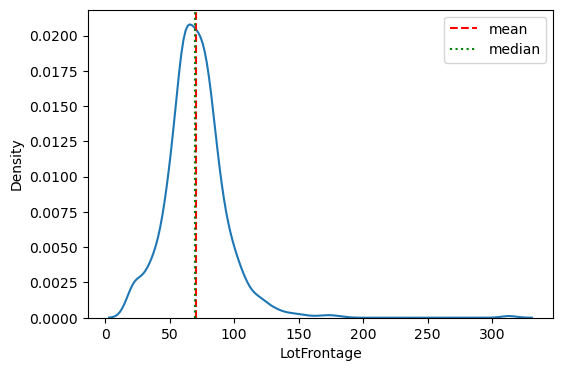

In [50]:
# set pyplot figure, and define the pre-defined size
plt.figure(figsize=(6,4))

# plot seaborn kdeplot for LotFrontage
sns.kdeplot(data = house_price_merged, x = "LotFrontage")

# draw vertical line to describe the mean value
plt.axvline(x = house_price_merged.LotFrontage.mean(), color = "r", linestyle = "dashed", label = "mean")

# draw vertical line to describe the median value
plt.axvline(x = house_price_merged.LotFrontage.median(), color = "g", linestyle = "dotted", label = "median")

# show the legend
plt.legend()

# show the whole graphic
plt.show()

From the visualization results, it is known that the median and mean values ​​are quite close. However, the data distribution is skewed to the right. Because this will use **median** to input the LotFrontage column

**Imputing Missing Value on LotFrontage**

In [51]:
house_price_merged['LotFrontage'] = house_price_merged['LotFrontage'].fillna(house_price_merged['LotFrontage'].median())

In [52]:
# sum all missing value in dataset and keep only columns with missing value > 0
missing = house_price_merged.isnull().sum()[house_price_merged.isnull().sum() > 0]

# construct a dataframe consists of NaN count and NaN percentage from the dataset
missing_house_price_summary = pd.DataFrame({
    'NaN_count': missing, 
    'NaN_percentage': round(((missing / len(house_price_merged)) * 100),3)
    }).sort_values(by = 'NaN_percentage', ascending = False)

# print the missing value information
missing_house_price_summary

,NaN_count,NaN_percentage
Electrical,1,0.073


**Missing Value on LotFrontage Imputation is Successful**

It can be seen that the missing value in the Electirical column only contains one observation. Because the data is very small compared to the entire data, we can delete the observation containing the missing value.

In [53]:
# Delete missing value on electrical column
house_price_merged.dropna(subset=["Electrical"], inplace=True)

In [54]:
# sum all missing value in dataset and keep only columns with missing value > 0
missing = house_price_merged.isnull().sum()[house_price_merged.isnull().sum() > 0]

# construct a dataframe consists of NaN count and NaN percentage from the dataset
missing_house_price_summary = pd.DataFrame({
    'NaN_count': missing, 
    'NaN_percentage': round(((missing / len(house_price_merged)) * 100),3)
    }).sort_values(by = 'NaN_percentage', ascending = False)

# print the missing value information
missing_house_price_summary

,NaN_count,NaN_percentage


## Detect and Handle Outlier

### Detect Outliers using Box Plot

In [55]:
# Select Numeric columns
numeric_cols = int_columns + float_columns

# Reset Index Merged Data
house_price_merged.reset_index()

,index,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,0,1,60,RL,65.0,8450,Pave,not_exist,Reg,Lvl,...,0,not_exist,not_exist,not_exist,0,2,2008,WD,Normal,208500
1,1,2,20,RL,80.0,9600,Pave,not_exist,Reg,Lvl,...,0,not_exist,not_exist,not_exist,0,5,2007,WD,Normal,181500
2,2,3,60,RL,68.0,11250,Pave,not_exist,IR1,Lvl,...,0,not_exist,not_exist,not_exist,0,9,2008,WD,Normal,223500
3,3,4,70,RL,60.0,9550,Pave,not_exist,IR1,Lvl,...,0,not_exist,not_exist,not_exist,0,2,2006,WD,Abnorml,140000
4,4,5,60,RL,84.0,14260,Pave,not_exist,IR1,Lvl,...,0,not_exist,not_exist,not_exist,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1373,1374,1456,60,RL,62.0,7917,Pave,not_exist,Reg,Lvl,...,0,not_exist,not_exist,not_exist,0,8,2007,WD,Normal,175000
1374,1375,1457,20,RL,85.0,13175,Pave,not_exist,Reg,Lvl,...,0,not_exist,MnPrv,not_exist,0,2,2010,WD,Normal,210000
1375,1376,1458,70,RL,66.0,9042,Pave,not_exist,Reg,Lvl,...,0,not_exist,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1376,1377,1459,20,RL,68.0,9717,Pave,not_exist,Reg,Lvl,...,0,not_exist,not_exist,not_exist,0,4,2010,WD,Normal,142125


In [56]:
# minimal subplot rows to make if we want 3 columns
import math
print(math.ceil(len(numeric_cols)/3))

10


/var/folders/hk/f18g1qcj7zl5r0nhqtpy80400000gn/T/ipykernel_11323/1079368416.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


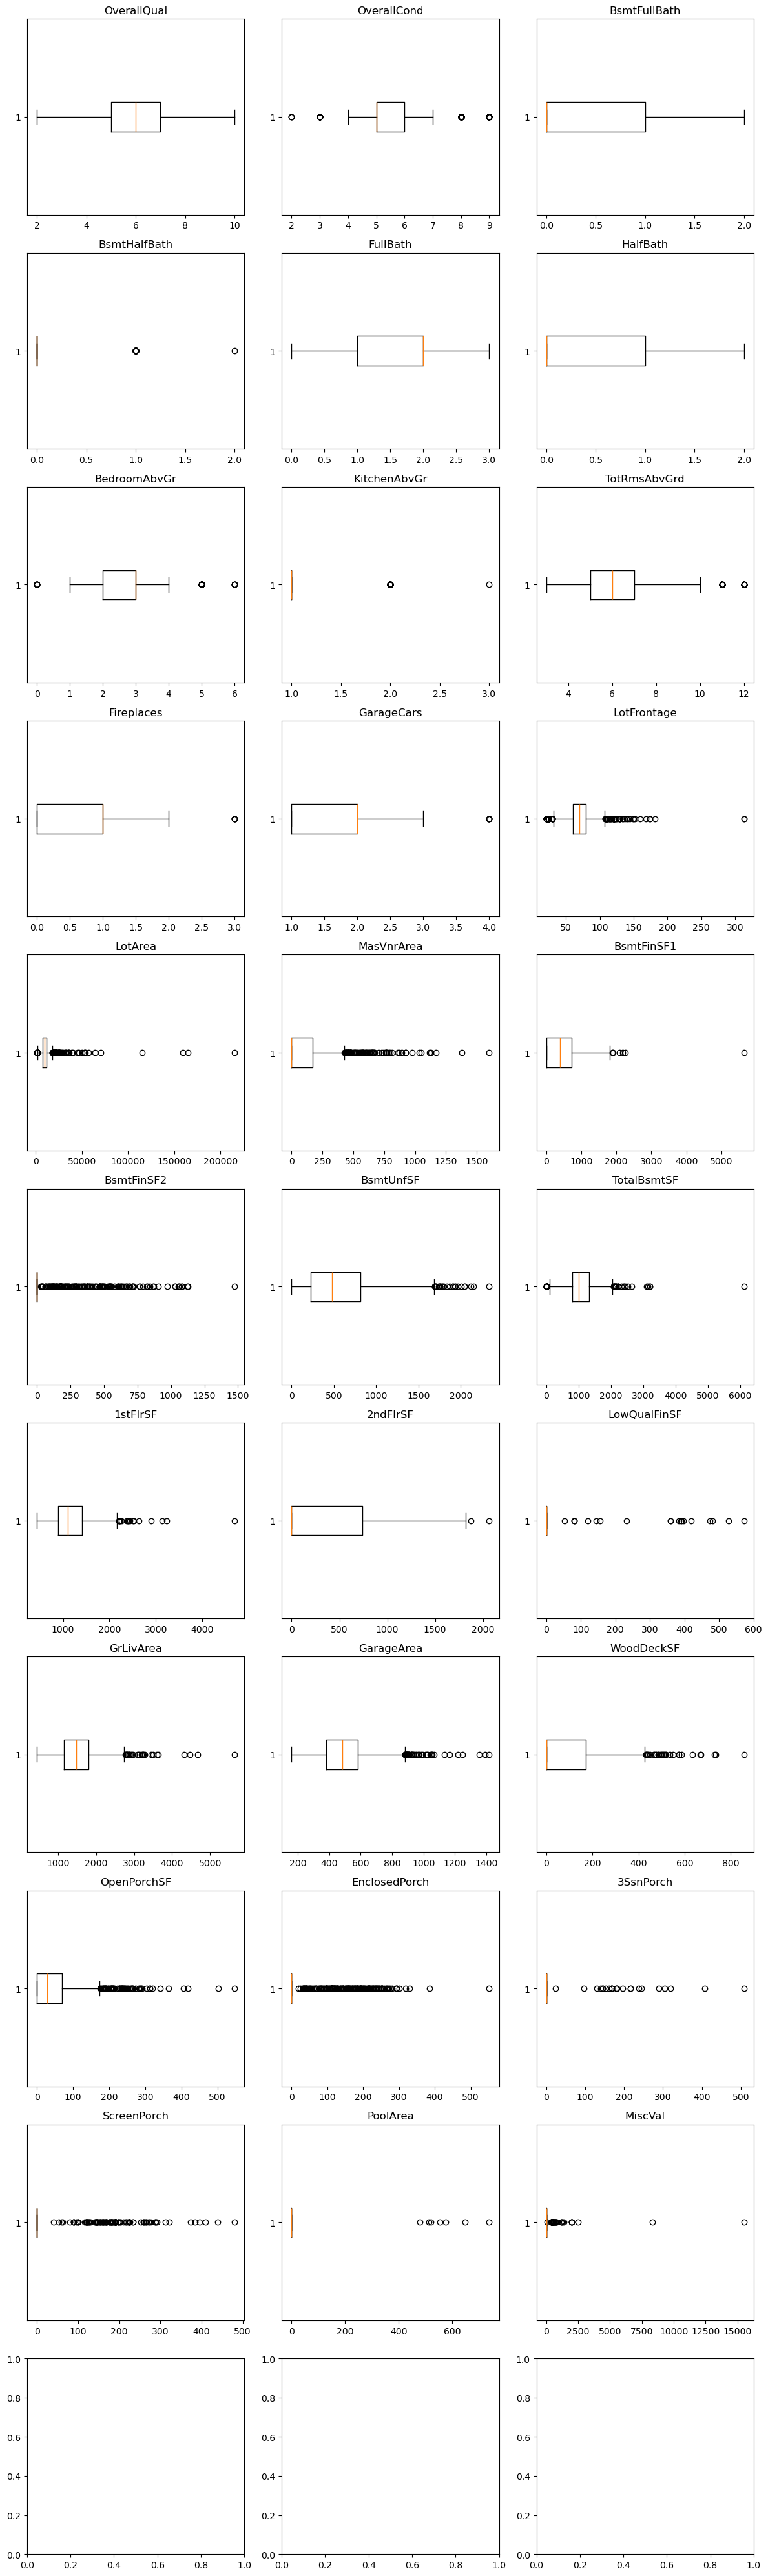

In [58]:
# create subplots with 11x3 grids and size 12x30
fig, ax = plt.subplots(11, 3, figsize=(12,40))

# counter to select colnames
cnt = 0

# loop through the grids
for i in range(11):

    if cnt >= 30:
            break

    for j in range(3):

        if cnt >= 30:
            break

        # we use boxplot from pyplot
        ax[i, j].boxplot(house_price_merged[numeric_cols[cnt]], vert=False)
        ax[i, j].set_title(str(numeric_cols[cnt]), fontdict={'fontsize':12})

        # increment counter
        cnt = cnt+1

# make sure layout is not overlapping
fig.tight_layout()
# show the graphs
fig.show()

### Detect Outliers using IQR Filter

In [64]:
# function to detect outlier using IQR
def detect_outliers_iqr(data):

    # initialize list that contains the outliers
    outliers = []

    # sort data values
    data = sorted(data)

    # compute the q1
    q1 = np.percentile(data, 25)

    # compute the q3
    q3 = np.percentile(data, 75)

    # compute the IQR
    IQR = q3-q1

    # set the lower bound
    ## note that we can play with value 1.5 to widen or narrow the range
    lower_bound = q1-(1.5*IQR)

    # set the upper bound
    ## note that we can play with value 1.5 to widen or narrow the range
    upper_bound = q3+(1.5*IQR)

    # print computed lower and upper bound of a particular column
    print("Lower Bound:",lower_bound, "| Upper Bound:", upper_bound)

    # for each data point, decide whether it falls below lower bound or above upper ground
    for i in data:

        if (i < lower_bound or i > upper_bound):

            outliers.append(i)

    return outliers

Get list of outlier columns

In [70]:
# put outlier columns (inferred from boxplot analysis above) in a list
outlier_columns = ["LotFrontage", "LotArea", "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "1stFlrSF",
"2ndFlrSF", "LowQualFinSF", "GrLivArea", "GarageArea", "WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch",
"PoolArea", "MiscVal"]
print(len(outlier_columns))

19


In [67]:
for col in outlier_columns:

    outlier = detect_outliers_iqr(house_price_merged[col])

    print(f"Number of outliers in column {col} : {len(outlier)}")
    print()

Lower Bound: 31.5 | Upper Bound: 107.5
Number of outliers in column LotFrontage : 98

Lower Bound: 1782.125 | Upper Bound: 17671.125
Number of outliers in column LotArea : 79

Lower Bound: -256.125 | Upper Bound: 426.875
Number of outliers in column MasVnrArea : 86

Lower Bound: -1098.0 | Upper Bound: 1830.0
Number of outliers in column BsmtFinSF1 : 6

Lower Bound: 0.0 | Upper Bound: 0.0
Number of outliers in column BsmtFinSF2 : 163

Lower Bound: -647.75 | Upper Bound: 1686.25
Number of outliers in column BsmtUnfSF : 26

Lower Bound: 54.625 | Upper Bound: 2069.625
Number of outliers in column TotalBsmtSF : 54

Lower Bound: 114.0 | Upper Bound: 2194.0
Number of outliers in column 1stFlrSF : 18

Lower Bound: -1108.125 | Upper Bound: 1846.875
Number of outliers in column 2ndFlrSF : 2

Lower Bound: 0.0 | Upper Bound: 0.0
Number of outliers in column LowQualFinSF : 19

Lower Bound: 200.0 | Upper Bound: 2744.0
Number of outliers in column GrLivArea : 29

Lower Bound: 78.5 | Upper Bound: 882.

In [71]:
# remove columns with lower and upper bound equal 0
outlier_columns=[out for out in outlier_columns if out not in ["BsmtFinSF2", "LowQualFinSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch", "PoolArea", "MiscVal"]]
outlier_columns

['LotFrontage',
 'LotArea',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'GrLivArea',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF']

In [72]:
len(outlier_columns)

12

/var/folders/hk/f18g1qcj7zl5r0nhqtpy80400000gn/T/ipykernel_11323/1892531301.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


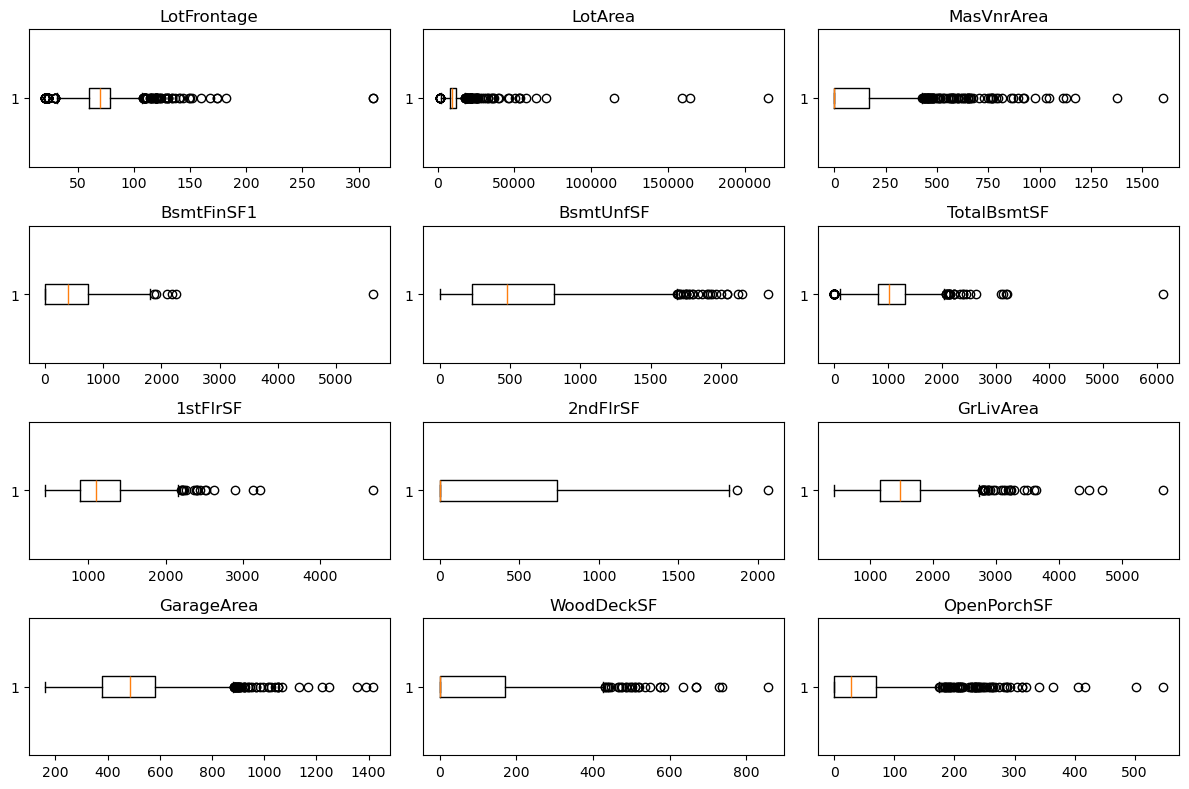

In [73]:
# create subplots with 4x3 grids and size 12x30
fig, ax = plt.subplots(4, 3, figsize=(12,8))

# counter to select outlier_columns
cnt = 0

# loop through the grids
for i in range(4):

    if cnt >= 12:
            break

    for j in range(3):

        if cnt >= 12:
            break

        # we use boxplot from pyplot
        ax[i, j].boxplot(house_price_merged[outlier_columns[cnt]], vert=False)
        ax[i, j].set_title(str(outlier_columns[cnt]), fontdict={'fontsize':12})

        # increment counter
        cnt = cnt+1

# make sure layout is not overlapping
fig.tight_layout()
# show the graphs
fig.show()

### Handle Outlier with Capping Method

capping detected outliers is a handful approach to handle our outliers since it isn't removing values (since it may be useful information).

capping comes in two approach:
* using IQR upper and lower bound
* using fixed quantile

for this task, we will use **fixed quantile** aproach.

**Fixed quantile** approach values as outliers if they are less than or more than the values for 97% of all the records in your dataset. In such cases you can use the `quantile()` method of the Pandas dataframe and pass it thresholds for lower and upper limits.

For instance, a threshold value of 0.03 for the `quantile()` method will find the values that are less than 97% of all the records in the dataset. Where as a threshold value of 97% returns values that are greater than 97% of the records.

further reading: [wellsr](https://wellsr.com/python/outlier-data-handling-with-python/)

In [74]:
# Import copy method
import copy

# Copy Original Data Frame
house_price_capped = copy.deepcopy(house_price_merged)

In [78]:
# Create function to filter outliers
def capping_outlier(col):

    # Define Lower Limit and Upper Limit
    lwr_limit = house_price_capped[col].quantile(0.03)
    upr_limit = house_price_capped[col].quantile(0.97)

    print(f'{col} Column')
    print(f"Lower Limit : {lwr_limit}")
    print(f"Upper Limit : {upr_limit}")
    print()

    # melakukan filter outlier
    house_price_capped[col] = np.where(house_price_capped[col]> upr_limit, upr_limit,
                                        np.where(house_price_capped[col]< lwr_limit, lwr_limit, house_price_capped[col]))

In [79]:
for col in outlier_columns:

    capping_outlier(col)

LotFrontage Column
Lower Limit : 31.047799999999988
Upper Limit : 114.0

LotArea Column
Lower Limit : 2610.8603999999996
Upper Limit : 21750.0

MasVnrArea Column
Lower Limit : 0.0
Upper Limit : 581.3805000000003

BsmtFinSF1 Column
Lower Limit : 0.0
Upper Limit : 1386.4761

BsmtUnfSF Column
Lower Limit : 0.0
Upper Limit : 1590.8566000000005

TotalBsmtSF Column
Lower Limit : 384.0
Upper Limit : 1923.9044000000004

1stFlrSF Column
Lower Limit : 630.0
Upper Limit : 1995.8088000000007

2ndFlrSF Column
Lower Limit : 0.0
Upper Limit : 1254.0

GrLivArea Column
Lower Limit : 834.0478
Upper Limit : 2633.4761

GarageArea Column
Lower Limit : 220.0
Upper Limit : 888.0

WoodDeckSF Column
Lower Limit : 0.0
Upper Limit : 392.9522000000002

OpenPorchSF Column
Lower Limit : 0.0
Upper Limit : 213.4761000000001

